In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random Forests Implementation

In [3]:
import pandas as pd
import numpy as np

seed = 420

np.random.seed(seed)

## Load Data

In [4]:
df = pd.read_csv('../../data/raw/training.csv', index_col=0)
# df.replace(-1, 99, inplace=True)

X = df.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = df['mobile_money_classification']

X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,-1,2,-1,1,-1,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,-1,2,-1,1,-1,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,-1,4,-1,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,-1,1,1,1,-1,1,4,-7.179645,31.039095


### Select 10% for independent testing

In [5]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=seed)

## Create Feature Engineering Pipeline

In [6]:
from src.features.transformers import MMAgentsInVicinity
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

from sklearn_pandas import DataFrameMapper, gen_features
from fastai.tabular import cont_cat_split

def to_nested_list(list):
    return [[l] for l in list]

lat_lon = ['Latitude', 'Longitude']

# Get categorical and continuous variables
cont_vars, cat_vars = cont_cat_split(X.drop(lat_lon, axis=1))

loc_feat_maps = [
    (lat_lon, MMAgentsInVicinity(radius=20), {'alias': 'mm_agents_20km'})
]

cat_var_maps = gen_features(to_nested_list(cat_vars))

cont_var_maps = gen_features(to_nested_list(cont_vars), [{'class': KBinsDiscretizer, 'n_bins': 7, 'encode': 'onehot-dense'}])

feature_maps = loc_feat_maps + cat_var_maps + cont_var_maps

features_pipeline = DataFrameMapper(feature_maps, df_out=True)

/Users/renier.botha/anaconda3/envs/mobile_money/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
/Users/renier.botha/anaconda3/envs/mobile_money/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (26,32,33,42,74) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


### Transform Training and Test sets 

In [7]:
print('Processing:')
print('Training')
data = features_pipeline.fit_transform(X)
print('Testing')
data_test = features_pipeline.fit_transform(X_test)
print('Done')
data.head()

Processing:
Training
Testing
Done


,mm_agents_20km,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q17,Q18,Q19,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6
ID,,,,,,,,,,,,,,,,,,,,,
3143,337,2,4,5,1,2,2,0,0,0,...,-1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9138,3,2,2,3,3,2,1,0,1,0,...,-1,1,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1105,674,2,4,4,1,2,1,0,0,0,...,-1,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2126,286,2,4,5,3,2,2,0,0,0,...,-1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5720,8,2,1,2,3,2,2,0,0,0,...,-1,4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, train_test_split

d_train, d_val, y_train, y_val = train_test_split(data, y, random_state=seed)

rf_classifier = RandomForestClassifier(n_estimators=40, max_depth=3, oob_score=True)

rf_classifier.fit(d_train, y_train)

val_probs = rf_classifier.predict_proba(d_val)

score = log_loss(y_val, val_probs)

print('Log Loss = ',score)

Log Loss =  0.9003846132647069


In [9]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_classifier, scoring='neg_log_loss', random_state=seed, n_iter=20)
perm.fit(d_val, y_val)

eli5.show_weights(perm, feature_names = list(d_val))

/Users/renier.botha/anaconda3/envs/mobile_money/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Weight,Feature
0.0874 ± 0.0088,Q14
0.0649 ± 0.0054,Q15
0.0638 ± 0.0063,Q12
0.0572 ± 0.0068,Q16
0.0377 ± 0.0039,Q7
0.0374 ± 0.0060,Q13
0.0066 ± 0.0017,Q18
0.0041 ± 0.0010,Q4
0.0035 ± 0.0012,Q17
0.0024 ± 0.0009,mm_agents_20km


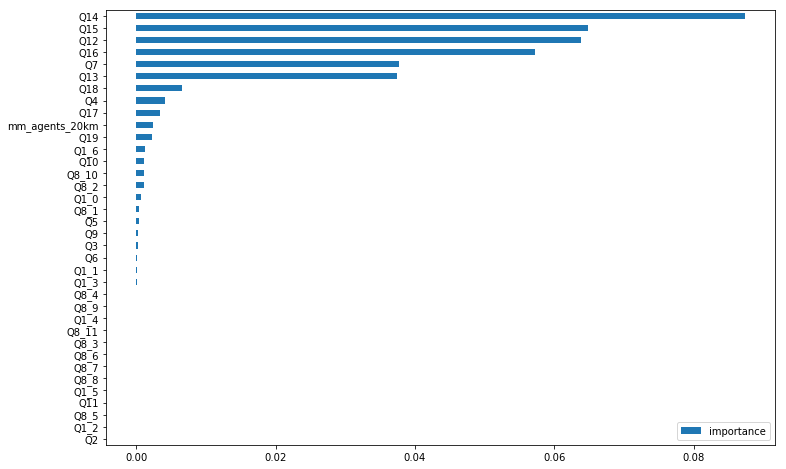

In [10]:
feat_imp_df = pd.DataFrame(perm.feature_importances_, index=list(d_val), columns=['importance']).sort_values(by='importance')
feat_imp_df.plot.barh(figsize=(12,8))

### Drop unimportant features

In [11]:
keep = list(feat_imp_df.tail(12).index)
keep

['Q1_6',
 'Q19',
 'mm_agents_20km',
 'Q17',
 'Q4',
 'Q18',
 'Q13',
 'Q7',
 'Q16',
 'Q12',
 'Q15',
 'Q14']

### Run model again

In [13]:
d_train = d_train[keep]
d_val = d_val[keep]

rf_classifier = RandomForestClassifier(n_estimators=40, max_depth=3, oob_score=True)

rf_classifier.fit(d_train, y_train)

val_probs = rf_classifier.predict_proba(d_val)

score = log_loss(y_val, val_probs)

print('Log Loss = ',score)

perm = PermutationImportance(rf_classifier, scoring='neg_log_loss', random_state=seed, n_iter=20)
perm.fit(d_val, y_val)

print('\n\nPermutation Importance')
eli5.show_weights(perm, feature_names = list(d_val))

Log Loss =  0.8686224376031431


Permutation Importance


Weight,Feature
0.1201 ± 0.0114,Q15
0.0886 ± 0.0105,Q16
0.0792 ± 0.0076,Q13
0.0502 ± 0.0063,Q14
0.0361 ± 0.0047,Q12
0.0297 ± 0.0046,Q7
0.0075 ± 0.0026,Q17
0.0062 ± 0.0016,Q18
0.0027 ± 0.0016,Q19
0.0014 ± 0.0007,Q4


In [14]:
import seaborn as sns
sns.set()

feat_imp_df = pd.DataFrame({'importance': perm.feature_importances_, 'std-dev': perm.feature_importances_std_},
                           index=list(d_val)).sort_values(by='importance')
feat_imp_df.head(10)

,importance,std-dev
mm_agents_20km,0.000802,0.000263
Q1_6,0.000839,0.000362
Q4,0.001410,0.000358
Q19,0.002702,0.000820
Q18,0.006222,0.000790
Q17,0.007534,0.001325
Q7,0.029731,0.002282
Q12,0.036121,0.002332
Q14,0.050208,0.003175
Q13,0.079156,0.003803


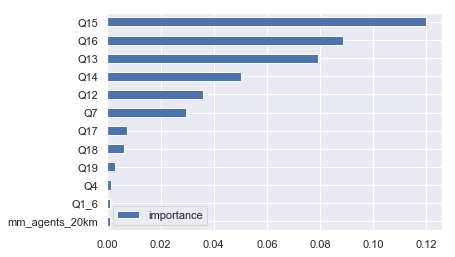

In [15]:
feat_imp_df.plot.barh(y='importance')

**Insight**

Q14 is now the most important feature

## Partial Dependence Plots

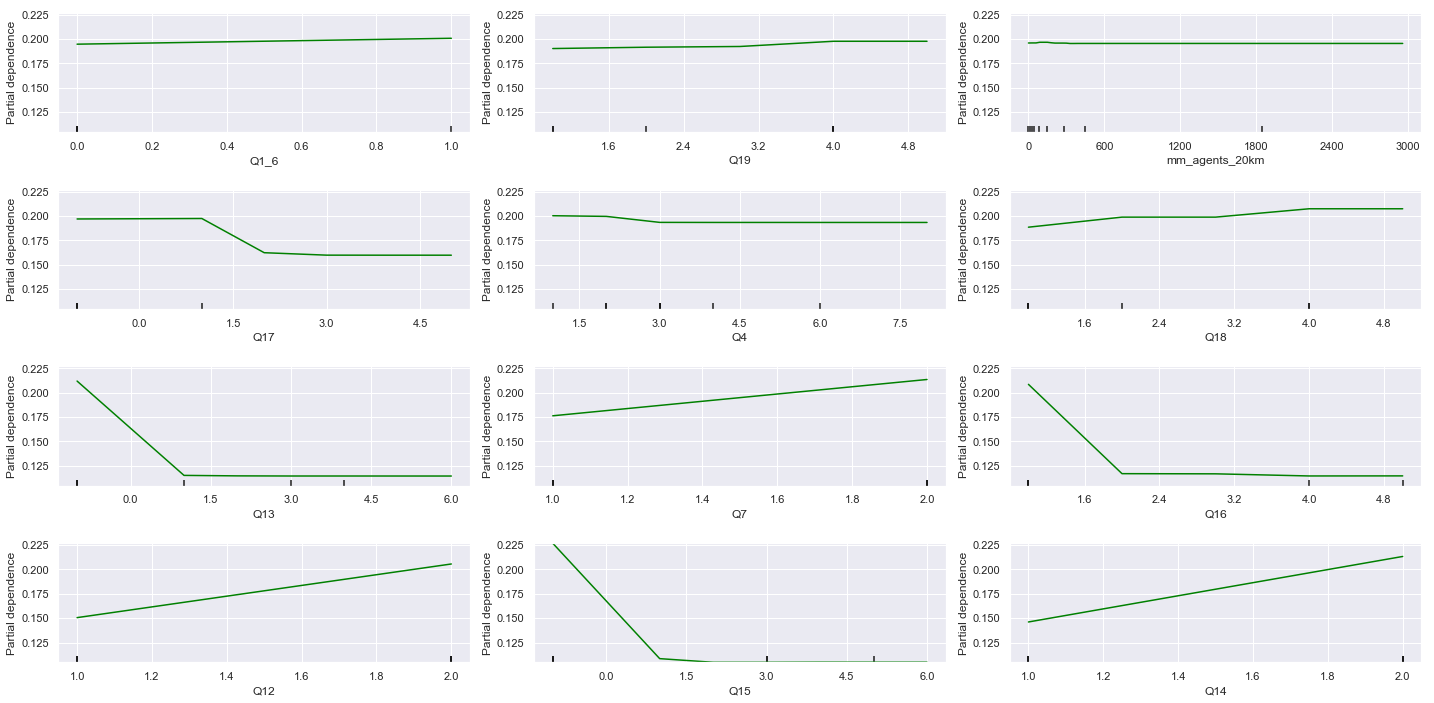

In [27]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence

fig = plt.figure(figsize=(20,10))
plot_partial_dependence(rf_classifier, d_train, features=list(d_train), feature_names=list(d_train), target=0, fig=fig, )
fig.tight_layout()

In [26]:
d_train.head()

,Q1_6,Q19,mm_agents_20km,Q17,Q4,Q18,Q13,Q7,Q16,Q12,Q15,Q14
ID,,,,,,,,,,,,
374,0.0,2,2566,-1,3,1,-1,1,5,2,-1,2
1210,0.0,1,391,-1,6,1,4,1,4,1,3,1
6553,0.0,4,20,-1,3,1,-1,2,1,2,-1,2
2019,0.0,4,445,-1,6,1,5,1,4,1,1,1
8194,0.0,4,150,-1,2,1,-1,2,1,2,4,1


In [ ]:
! pip install --upgrade scikit-learn